In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import obspy
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
from pyproj import Geod
from obspy.clients.fdsn import Client

In [29]:
ref_location = 19.485901834882345, -155.30471152157713
startdate = UTCDateTime('2010-01-01')
enddate = UTCDateTime('2024-01-01')
offset = 1.
minmagnitude = 3.
maxdepth = 15.

opt_catalog = dict(
    starttime = startdate,
    endtime = enddate,
    maxlongitude = min(ref_location[1]+offset, 180.),
    maxlatitude = min(ref_location[0]+offset, 90.),
    minlongitude = max(ref_location[1]-offset, -180.),
    minlatitude = max(ref_location[0]-offset, -90.),
    minmagnitude=minmagnitude, 
    maxdepth=maxdepth,
    includeallorigins=True,
    #includearrivals=True
)
    
client = Client("USGS")
catalog = client.get_events(**opt_catalog)
print(catalog)

2473 Event(s) in Catalog:
2023-12-29T01:16:31.220000Z | +19.166, -155.421 | 4.36 ml | manual
2023-12-09T07:22:52.610000Z | +19.378, -155.491 | 3.35 md | manual
...
2010-01-18T22:02:30.050000Z | +19.981, -155.848 | 3.08 ml | manual
2010-01-15T17:34:49.420000Z | +19.406, -155.306 | 3.0  ml | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [20]:
mags = np.array([ev.magnitudes[0].mag for ev in catalog])
id_large = np.argmax(mags)
#catalog[id_large]
nb_mt = np.array([len(ev.focal_mechanisms) for ev in catalog])
id_mt = np.where(nb_mt>0)[0]
catalog[id_mt[0]].focal_mechanisms[0].moment_tensor

MomentTensor
	   derived_origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/moment-tensor/us_7000lgb4_mwr_slm/us/1707608852040/product.xml#origin")
	 moment_magnitude_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/moment-tensor/us_7000lgb4_mwr_slm/us/1707608852040/product.xml#magnitude")
	              tensor: Tensor(m_rr=5970000000000000.0, m_tt=-1.14e+16, m_pp=5430000000000000.0, m_rt=1.17e+16, m_rp=1.16e+16, m_tp=-1550000000000000.0)
	       double_couple: 0.0

In [27]:
catalog[0].magnitudes

[Magnitude
	     resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/hv73699997/hv/1703813439950/product.xml#magnitude")
	             mag: 4.36 [uncertainty=0.166234414960689]
	  magnitude_type: 'ml'
	       origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/hv73699997/hv/1703813439950/product.xml")
	   station_count: 46
	 evaluation_mode: 'manual'
	   creation_info: CreationInfo(agency_id='HV', creation_time=UTCDateTime(2023, 12, 29, 1, 30, 39, 950000)),
 Magnitude
	     resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us6000m0b2/us/1709415573040/product.xml#magnitude")
	             mag: 4.4 [uncertainty=0.103]
	  magnitude_type: 'mb'
	       origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us6000m0b2/us/1709415573040/product.xml")
	   station_count: 27
	 evaluation_mode: 'manual'
	   creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2024, 3, 2, 21, 39, 

In [26]:
depths = [ev.origins[0].depth/1e3 for ev in catalog]
mags = [ev.magnitudes[0].mag for ev in catalog]
times = [(ev.origins[0].time - startdate)/(3600*24*365) for ev in catalog]
UTC_times = [ev.origins[0].time.datetime for ev in catalog]

catalog_hawai = pd.DataFrame(np.array([pd.to_datetime(UTC_times), times, depths, mags]).T, columns=['UTC', 'time (years)', 'depth', 'mag'])
catalog_hawai.to_csv('./data/hawai_catalog.csv', header=True, index=False)

In [ ]:
catalog_hawai

<IPython.core.display.Javascript object>


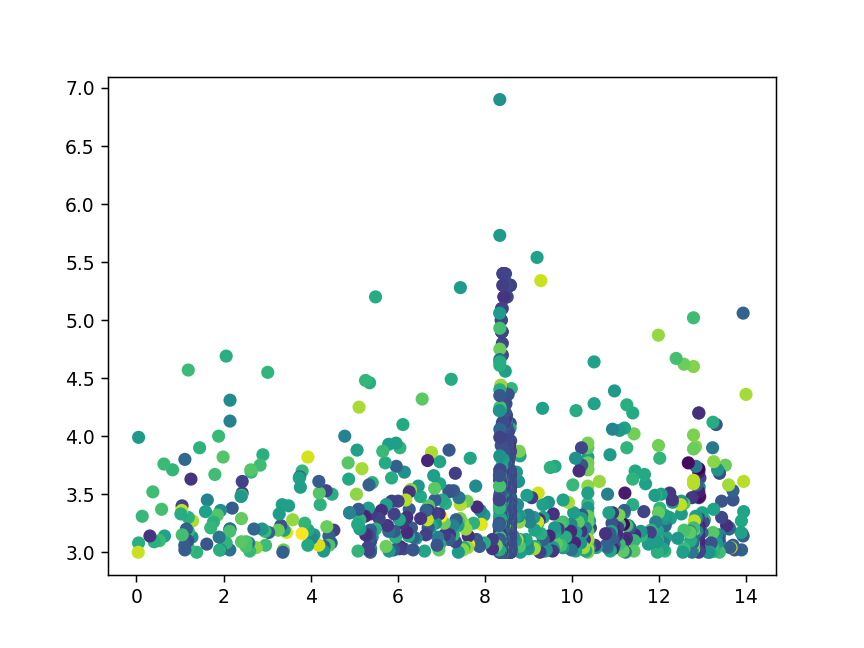

In [8]:
plt.figure()
plt.scatter(times, mags, c=depths)